In [98]:
library(tensorflow)
library(EBImage)
library(XML)
library(stats)
library(RJSONIO)
library(rPython)
library(leaflet)
library(htmlwidgets)

python.load("omrekenen.py")

# The aim of this script

We want to determine the location of buoys using a series of gps labeled photos.

This allows us to place cameras on ships that can automatically alarm us, if anything were to be missing.

# Data exploration

In the folder db/test we find three photos. The csv file db/test_location gives us the gps locations of the photos. We display the data herunder.

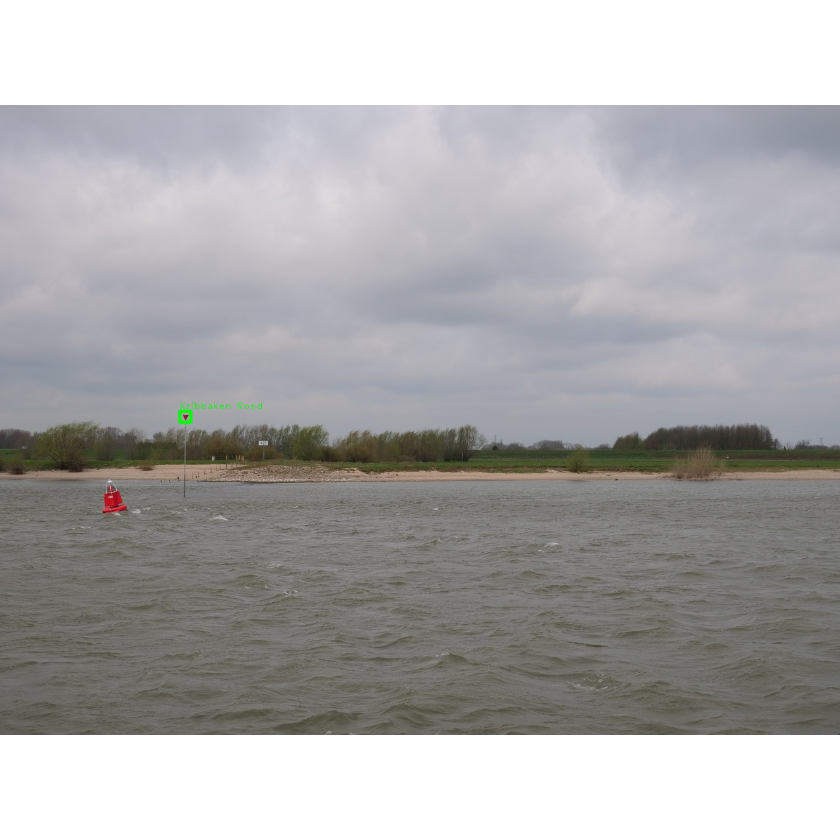

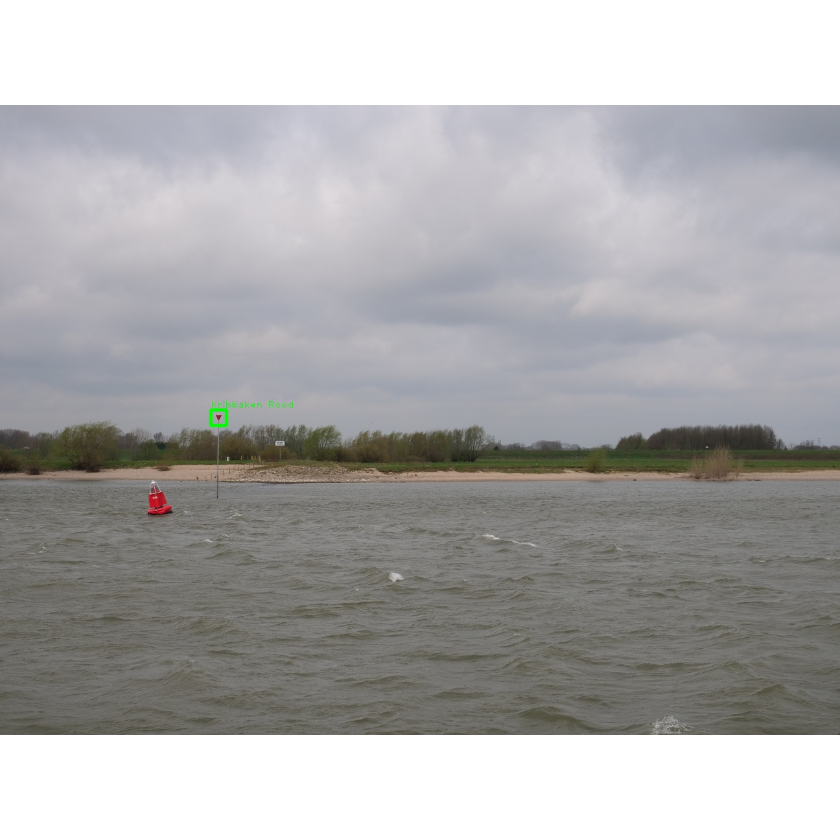

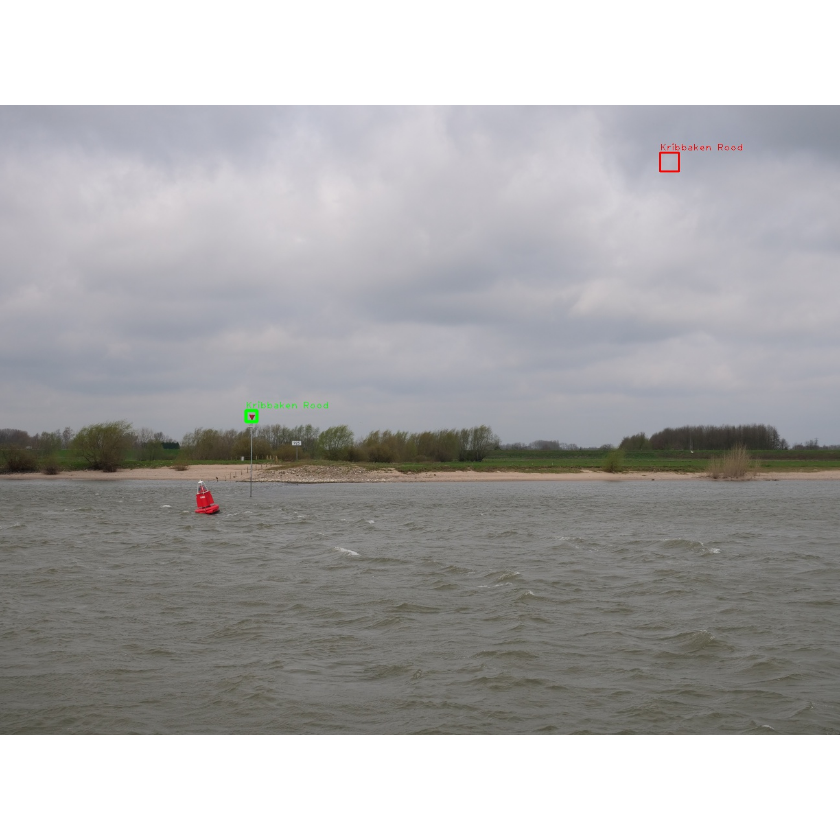

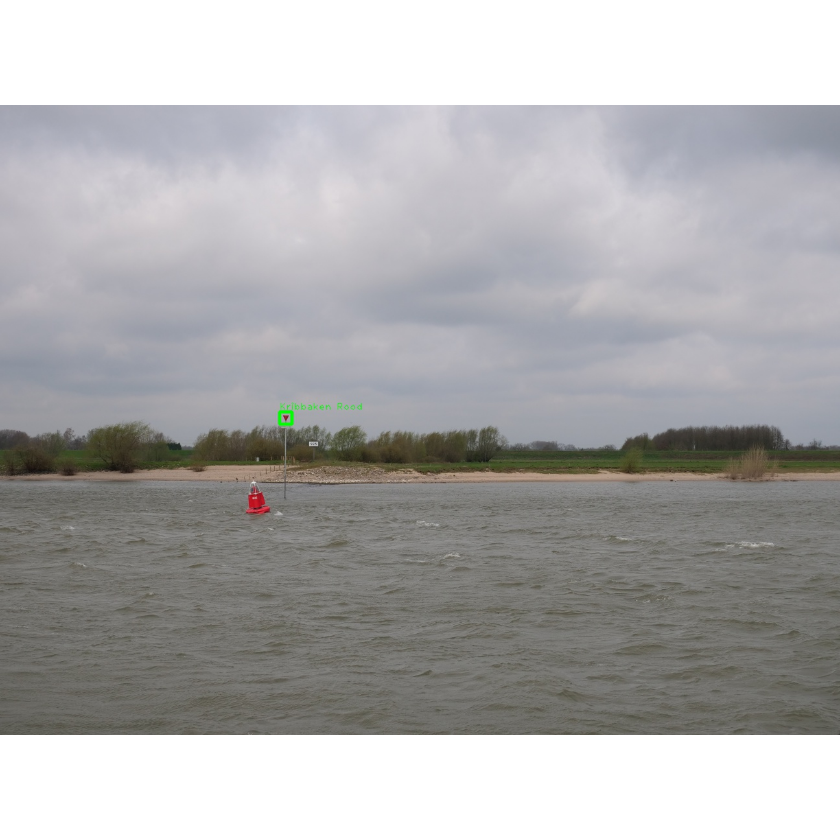

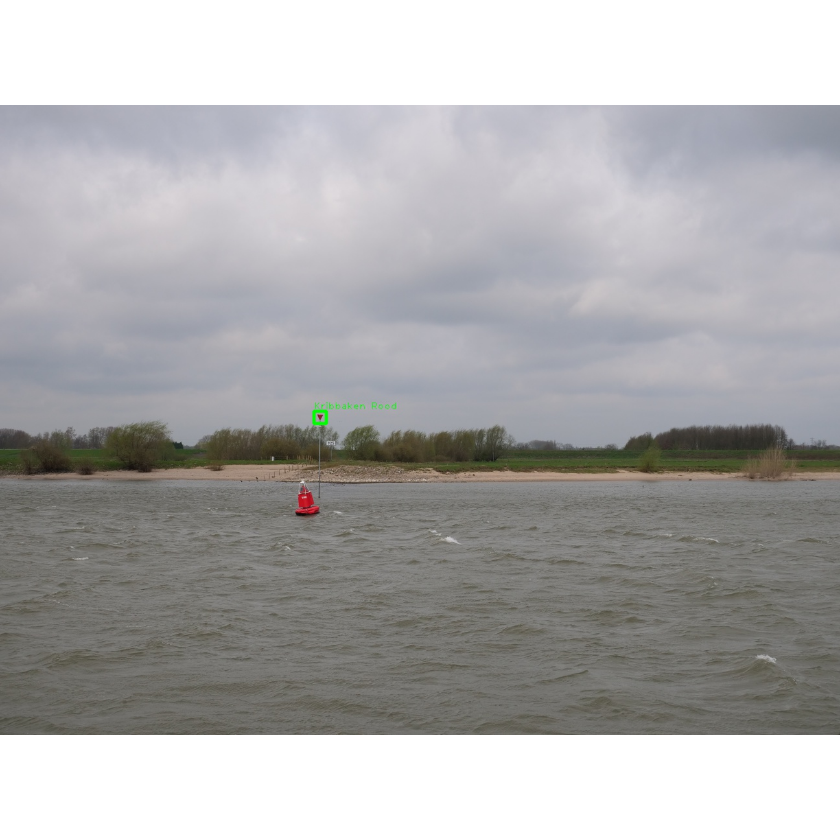

In [99]:
photos = list.files('db/test', full.name = TRUE)
for(im in photos){
im = readImage(im)
display(im)
    }

In [100]:
locations = read.csv('db/test_locations.csv', header = FALSE)
colnames(locations) = c('lat', 'lon')
print(locations)

     lat    lon
1 137007 425083
2 137010 425082
3 137013 425080
4 137016 425077
5 137018 425079


The first task, and the task in which we preform some deeplearning, is to determine which pixels in the photo belong to the buoy and which pixels do not.

For this we train an network to classify the pixels in the image. In the folder db/boeien we have a large number of photos of buoys and in train_labels.csv we have for each photo a square indicating the position of the buoy.

Let's have a look at the positions table

In [101]:
table = read.csv('db/train_labels.csv')
head(table)

X.1 X  naam                      xmin ymin xmax ymax wx wy
1  1   1 db/boeien/Frame000012.jpg   8  571   51  636  43 65
2  2   2 db/boeien/Frame000013.jpg  82  576  123  630  41 54
3  8   8 db/boeien/Frame000019.jpg 526  580  567  636  41 56
4  9   9 db/boeien/Frame000020.jpg 609  579  644  630  35 51
5 10  10 db/boeien/Frame000021.jpg 684  579  726  637  42 58
6 11  11 db/boeien/Frame000022.jpg 759  580  805  641  46 61

Let's display the image of a random row i of the table and let's draw a square according to the xmax, ymax, xmin and ymin

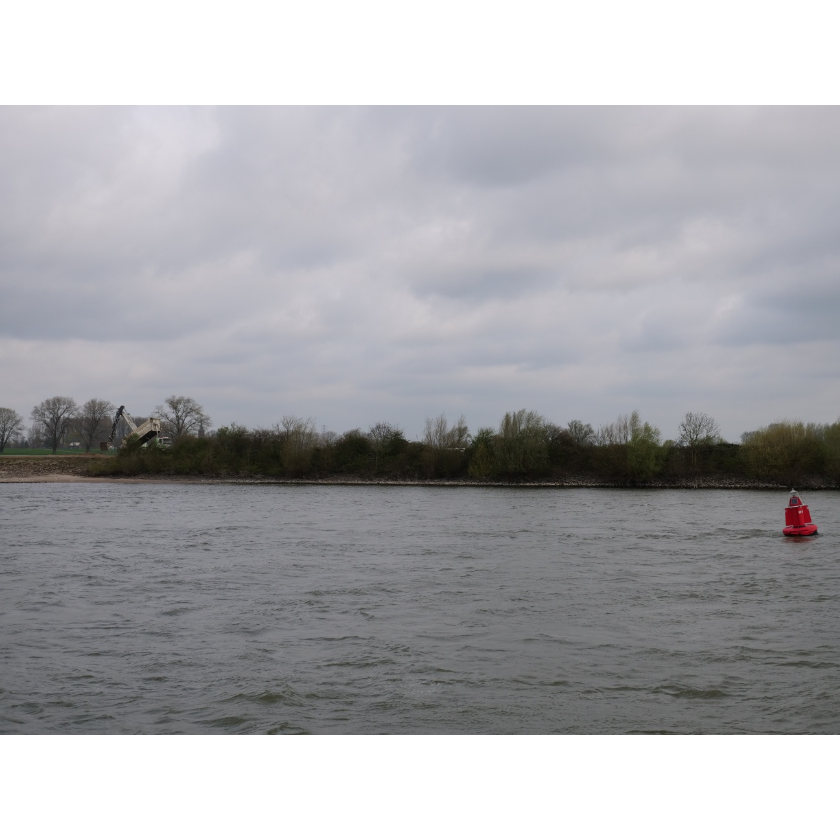

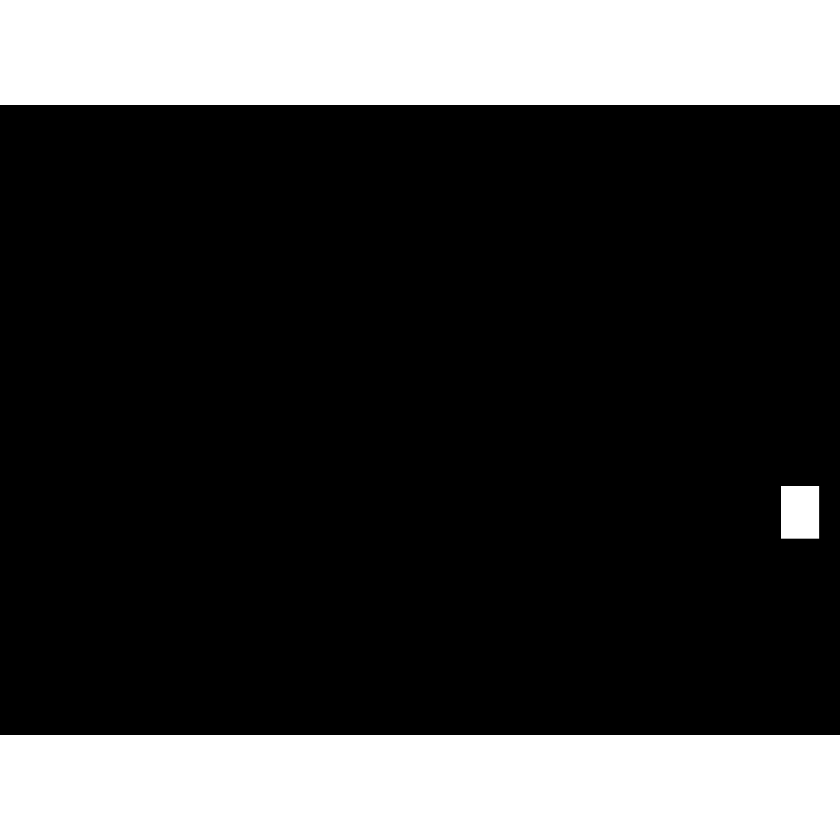

In [102]:
i = sample(x = c(1:nrow(table)), size = 1)
im = table$naam[i]
im = readImage(paste0( im))
display(im)

segmentation = array(0, dim = dim(im)[1:2])
segmentation[table$xmin[i]:table$xmax[i], table$ymin[i]:table$ymax[i]] = 1
display(segmentation)


The data seems to be allright.

# Per pixel classification

Now lets built a network to reproduce such an image segmentation.

In [23]:
clas = as.integer(2) #aantal klassen
lr = 1e-2 #learningrate
kanalen = as.integer(3) #kanalen image
h= as.integer(972)
w = as.integer(1296)
###############


#############
#place holders
#input
x <- tf$placeholder(tf$float32, shape(NULL, w , h, kanalen))
#target values
label <- tf$placeholder(tf$int32, shape(NULL,w, h))





############variabelen
w_conv1 <-tf$Variable(tf$truncated_normal(shape(10L, 10L, 3L, 8L), stddev=0.1), 'w_conv1')
b_conv1 <- tf$Variable(tf$truncated_normal(shape(1L, 8L), stddev=0.1), 'b_conv1')  
#w_conv2 <- tf$Variable(tf$truncated_normal(shape(4L, 4L,   8L, 8L), stddev=0.1), 'w_conv2')
#b_conv2 <- tf$Variable(tf$truncated_normal(shape(1L, 8L), stddev=0.1), 'b_conv2')  
#w_conv3 <- tf$Variable(tf$truncated_normal(shape(4L, 4L,   8L, 8L), stddev=0.1), 'w_conv3')
#b_conv3 <- tf$Variable(tf$truncated_normal(shape(1L, 8L), stddev=0.1), 'b_conv3')  
w_out <- tf$Variable(tf$truncated_normal(shape(1L, 1L,   8L, clas), stddev=0.1), 'w_upconv1')
b_out <- tf$Variable(tf$truncated_normal(shape(1L, clas), stddev=0.1), 'b_upconv1')  
#################


###################### De graph
h_conv1 <- tf$nn$relu(  tf$nn$conv2d(x, w_conv1, strides=c(1L, 1L, 1L, 1L), padding='SAME') + b_conv1 )
#h_conv2 = tf$nn$relu(  tf$nn$conv2d(h_conv1, w_conv2, strides=c(1L, 1L, 1L, 1L), padding='SAME') + b_conv2 )
#h_conv3 = tf$nn$relu(  tf$nn$conv2d(h_conv2, w_conv3, strides=c(1L, 1L, 1L, 1L), padding='SAME') + b_conv3 )

out =   tf$nn$conv2d(h_conv1, w_out, strides=c(1L, 1L, 1L, 1L), padding='SAME') + b_out 
out_softmax = tf$nn$softmax(out, dim = -1L)
################


################
#fout functie
label_onehot = tf$one_hot(label, depth = clas)
cost  = - tf$reduce_mean(  tf$multiply( label_onehot  ,  tf$log(    tf$clip_by_value(out_softmax, clip_value_min =  1e-10, clip_value_max = 1)   ) ) )

train_step <- tf$train$AdamOptimizer(lr)$minimize(cost)

#####################


###########
#maak sessie
sess <- tf$InteractiveSession()
sess$run(tf$global_variables_initializer())
###############



Now let's train this network.

In [24]:

for (i in 1:100) {
  
  #lees andom plaatjes in
  samp = sample( x=  c(1: nrow(table)) , size = 1 )
  
  print( as.character(table$naam[samp]))
  
im =   readImage( as.character(table$naam[samp]) )
 im = array( im, dim = c(1,dim(im)) )
 
  lab = array(0, dim =  dim(im)[1:3]) 
  lab[1,table$xmin[samp]:table$xmax[samp], table$ymin[samp]:table$ymax[samp]] = 1
 
 
  #train met gradient descent
  train_step$run(feed_dict = dict(x = im , label = lab))
  
 
}



[1] "db/boeien/Frame000274.jpg"
[1] "db/boeien/Frame003927.jpg"
[1] "db/boeien/Frame000670.jpg"
[1] "db/boeien/Frame000156.jpg"
[1] "db/boeien/Frame000021.jpg"
[1] "db/boeien/Frame002762.jpg"
[1] "db/boeien/Frame003801.jpg"
[1] "db/boeien/Frame000675.jpg"
[1] "db/boeien/Frame003799.jpg"
[1] "db/boeien/Frame002654.jpg"
[1] "db/boeien/Frame002763.jpg"
[1] "db/boeien/Frame000554.jpg"
[1] "db/boeien/Frame003996.jpg"
[1] "db/boeien/Frame004001.jpg"
[1] "db/boeien/Frame002768.jpg"
[1] "db/boeien/Frame002965.jpg"
[1] "db/boeien/Frame000355.jpg"
[1] "db/boeien/Frame000148.jpg"
[1] "db/boeien/Frame002869.jpg"
[1] "db/boeien/Frame004095.jpg"
[1] "db/boeien/Frame002964.jpg"
[1] "db/boeien/Frame004001.jpg"
[1] "db/boeien/Frame002657.jpg"
[1] "db/boeien/Frame002972.jpg"
[1] "db/boeien/Frame000554.jpg"
[1] "db/boeien/Frame000271.jpg"
[1] "db/boeien/Frame002966.jpg"
[1] "db/boeien/Frame000142.jpg"
[1] "db/boeien/Frame003927.jpg"
[1] "db/boeien/Frame002655.jpg"
[1] "db/boeien/Frame000027.jpg"
[1] "db/

Let's see how the network preforms on our test data.

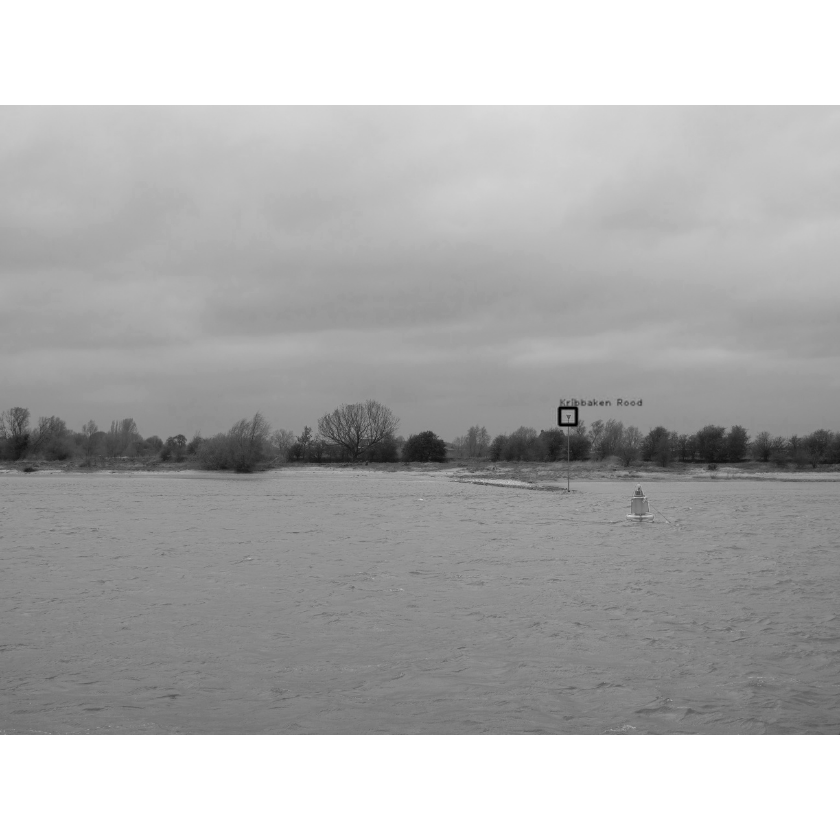

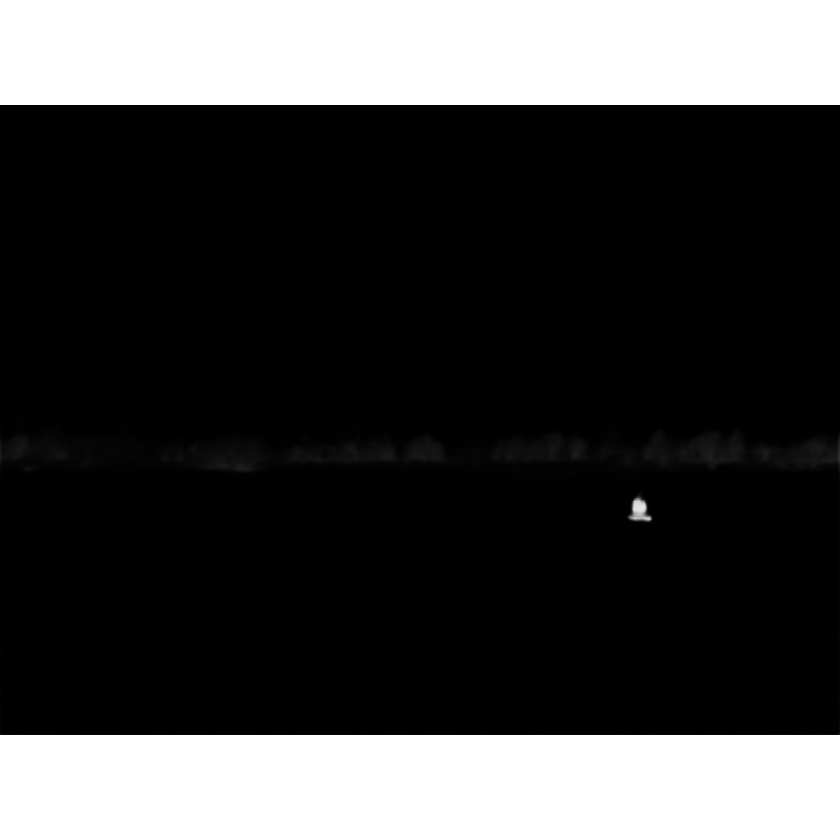

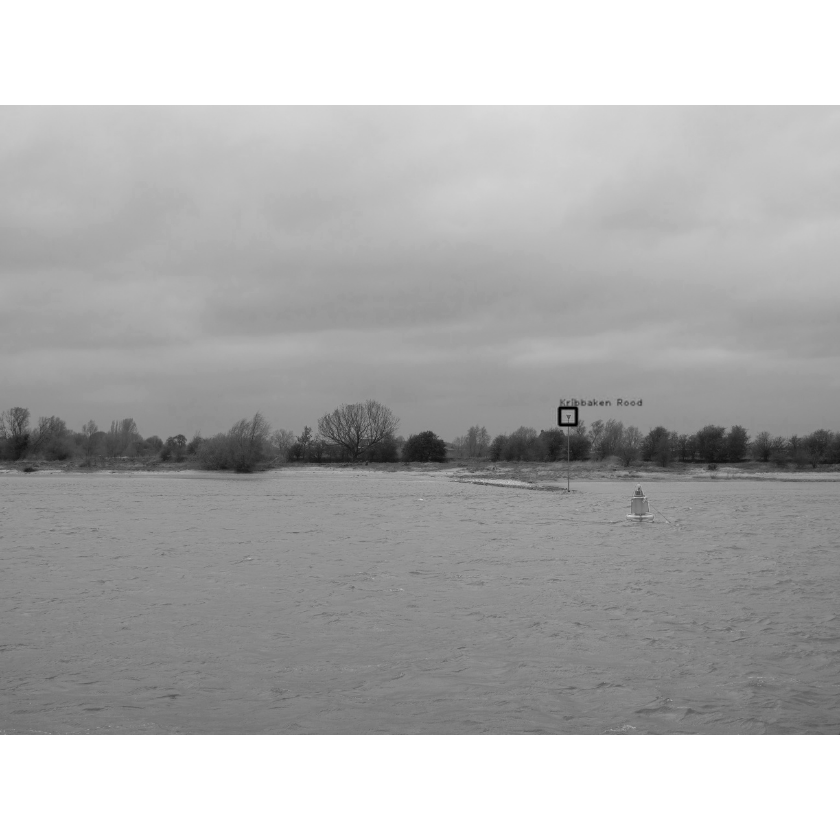

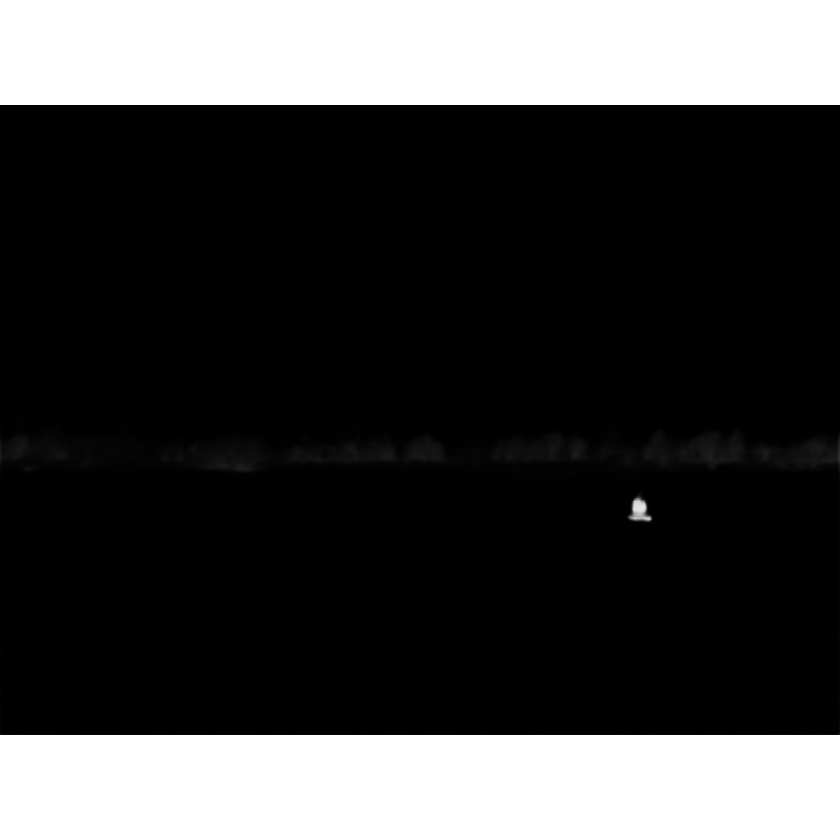

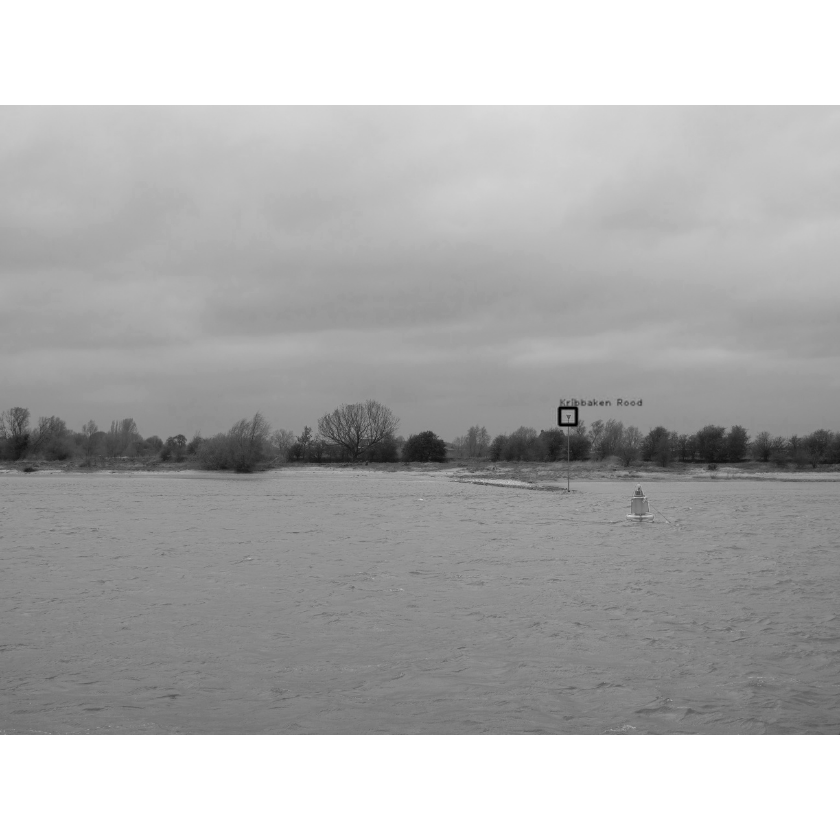

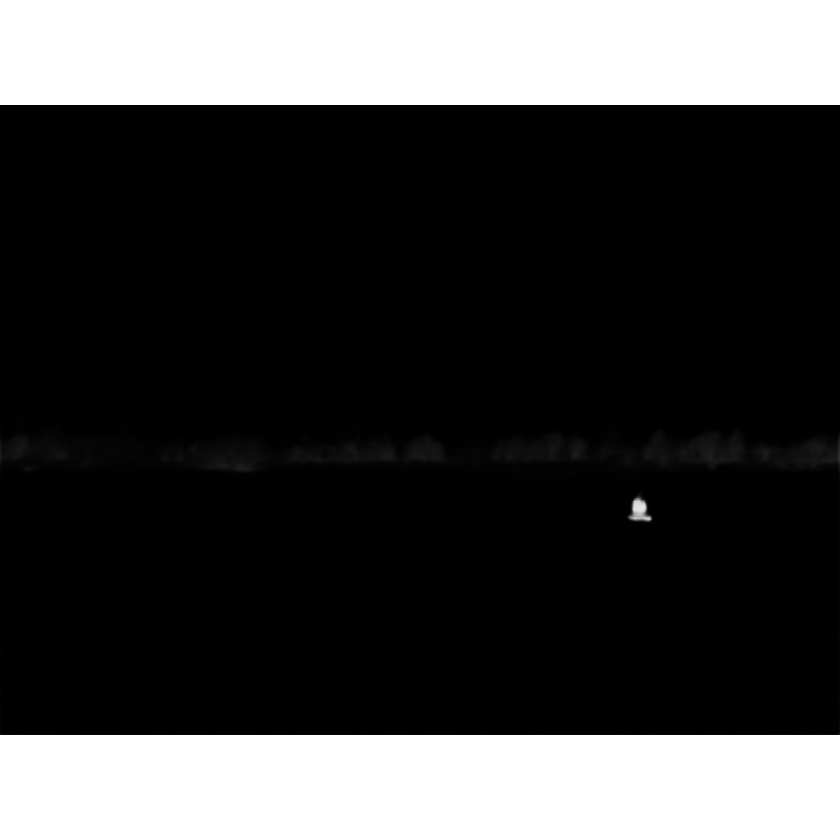

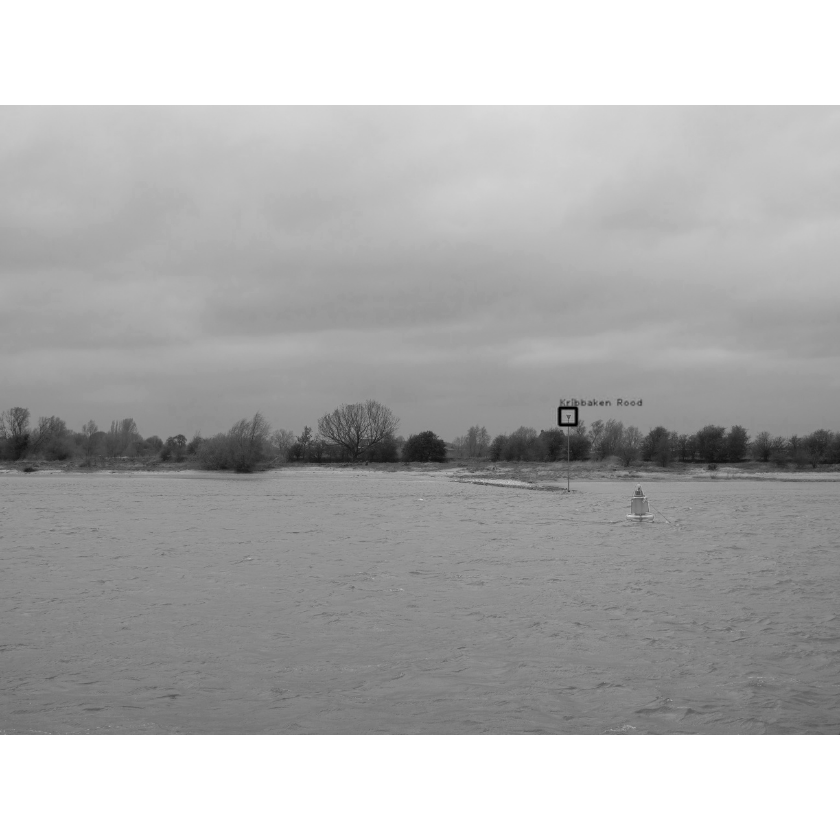

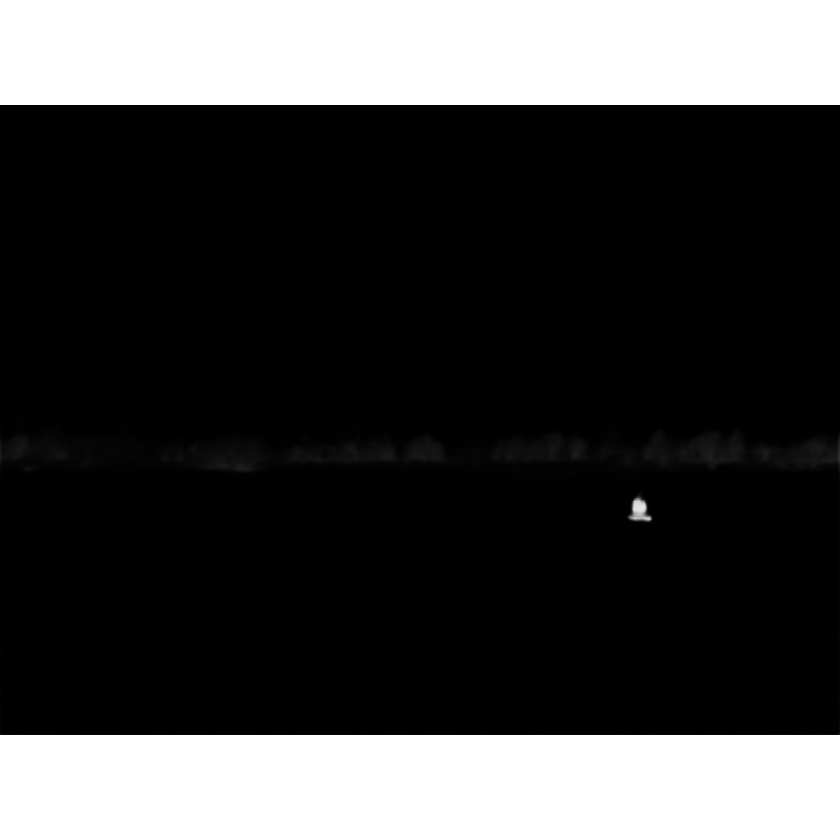

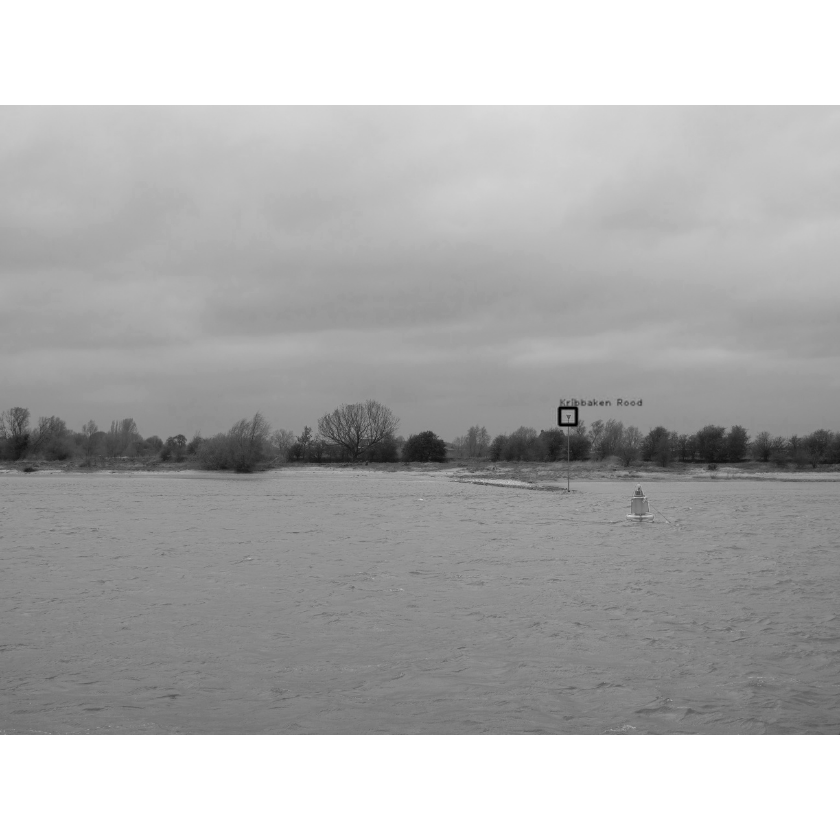

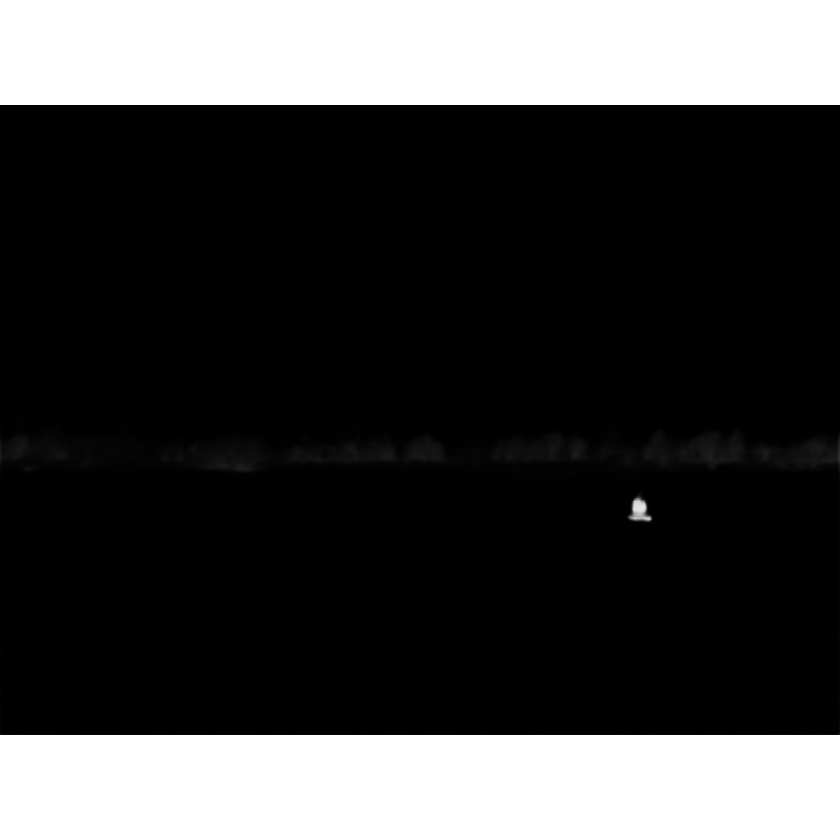

In [103]:
photos = list.files('db/test', full.name = TRUE)
for(im in photos){

im =   readImage( as.character(table$naam[samp]) )
im = array( im, dim = c(1,dim(im)) )

    
output = sess$run(out_softmax, feed_dict = dict(x = im))

display(im[1,,,1])
display(output[1,,,2])
    }

If evrything went well the result should look a bit like the following images.

<img src="notebook_images/3foto.jpg">
<img src="notebook_images/3uitkomst.jpg">

# Determining the position in the photo

In the previous step we obtained a heatmap in which pixels are brither when the computer deems it likely that the pixel is part of the buoy.

If the sum of all pixels around a pixel cross a certain threshold we say it is part of a buoy. Next we downsize the photo a factor 10 to merge all pi

Let's

In [104]:
photos = list.files('db/test', full.name = TRUE)
thershold = 15
sd_thershold1 = 100000

positions = list()

for( i in 1:nrow(locations)){
 im = photos[i]
  im =   readImage( im )
  im = array( im, dim = c(1,dim(im)) )
  
  
  output = sess$run(out_softmax, feed_dict = dict(x = im))
  output = as.matrix(output[1,,,2])

w = matrix(1, ncol = 11 , nrow = 11 )

output_filter = filter2(output, w)

output_filter = output_filter > thershold

position_buoy = which(output_filter == max(output_filter), arr.ind = TRUE)

    
#if sd is smaller than threshold_sd it is only one buoy   
if( sd(position_buoy[,1])*sd(position_buoy[,2]) <  sd_thershold1 ){ k=1}  
if( sd(position_buoy[,1])*sd(position_buoy[,2]) >  sd_thershold1 ){ k=2}  
      
new = as.data.frame( kmeans( position_buoy,k)$centers  )  
colnames(new)= c('col', 'row')
    
positions[[i]] = new 



}

print(positions)

[[1]]
       col      row
1 175.1985 613.0693

[[2]]
       col      row
1 224.9289 611.8338

[[3]]
       col      row
1 273.1114 606.4958

[[4]]
       col      row
1 338.7429 606.1475

[[5]]
       col      row
1 412.2379 608.0567



# Calculating the angle with the camera

Based on the position of the buoy in the photo we can calculate the angle the buoy makes with the camera.

The distance between the film and the lens was 4 cm and the width of the film was 5 cm.

<img src="notebook_images/image.gif">

In [105]:
for( i in 1:length(positions)){
 position_on_film = 5 * (positions[[i]]$col / 1296 - 0.5 )
  positions[[i]]$angle = atan(  position_on_film / 5)  
}

print(positions)

[[1]]
       col      row      angle
1 175.1985 613.0693 -0.3498124

[[2]]
       col      row      angle
1 224.9289 611.8338 -0.3155372

[[3]]
       col      row      angle
1 273.1114 606.4958 -0.2815801

[[4]]
       col      row      angle
1 338.7429 606.1475 -0.2342438

[[5]]
       col      row      angle
1 412.2379 608.0567 -0.1799474



# Calculating the lines on which the buoys lie

Based on the locations table constructed in the above we can calculate the position of the buoy.

First we calculate the angle the boat makes with respect to the coordinate system. We add this value to the angle between the buoy and the camera with respect to the coordinate system. We add 0.25 * pi since the camera films perpendicular to the ships movement.

In [106]:
locations_next = rbind(locations, NA)[-1,]
locations_rel = locations_next - locations

locations$angle_boat = tan( locations_rel$lon  / locations_rel$lat )


for( i in 1:length(positions)){
positions[[i]]$absolute_angle =  locations$angle_boat[i] + 0.25 * pi - positions[[i]]$angle 
}

print(positions)

[[1]]
       col      row      angle absolute_angle
1 175.1985 613.0693 -0.3498124       0.788957

[[2]]
       col      row      angle absolute_angle
1 224.9289 611.8338 -0.3155372      0.3140925

[[3]]
       col      row      angle absolute_angle
1 273.1114 606.4958 -0.2815801     -0.4904294

[[4]]
       col      row      angle absolute_angle
1 338.7429 606.1475 -0.2342438        2.57705

[[5]]
       col      row      angle absolute_angle
1 412.2379 608.0567 -0.1799474             NA



Based on this we can calculate the coefficiet and offset of the line with respect to the coordinate system.

In [107]:
for( i in 1:length(positions)){
    positions[[i]]$coeficient = tan(positions[[i]]$absolute_angle)
    positions[[i]]$offset = locations$lon[i] - positions[[i]]$coeficient * locations$lat[i]

    }


print(positions)

[[1]]
       col      row      angle absolute_angle coeficient   offset
1 175.1985 613.0693 -0.3498124       0.788957   1.007143 287097.3

[[2]]
       col      row      angle absolute_angle coeficient   offset
1 224.9289 611.8338 -0.3155372      0.3140925  0.3248458 380574.9

[[3]]
       col      row      angle absolute_angle coeficient   offset
1 273.1114 606.4958 -0.2815801     -0.4904294 -0.5339399 498236.7

[[4]]
       col      row      angle absolute_angle coeficient   offset
1 338.7429 606.1475 -0.2342438        2.57705 -0.6332963 511848.7

[[5]]
       col      row      angle absolute_angle coeficient offset
1 412.2379 608.0567 -0.1799474             NA         NA     NA



# Calculating the position of the buoy

The buoy lies on the intersection of these lines. We calculate the intersection of the first two photos.

In [108]:
n = 1
m= 2

x_intersect = (positions[[n]]$offset[1] - positions[[m]]$offset[1]) / (positions[[m]]$coeficient[1] - positions[[n]]$coeficient[1])
y_intersect  =   positions[[n]]$coeficient[1] * x_intersect +   positions[[n]]$offset[1] 

print( paste('x_intersect:', x_intersect , 'y_intersect:' , y_intersect))

[1] "x_intersect: 137004.106045607 y_intersect: 425080.085373459"


# Plot positions on a leaflet

We calculate the position in wgs coordinates and plot it in a leaflet.

In [109]:
coords = c(x_intersect, y_intersect)
python.assign('RDCoords', coords)
python.exec('coords = conv.fromRdToWgs( RDCoords )')
coords = python.get('coords')

In [110]:
coords

[1] 51.814053  5.126171

In [111]:
m = leaflet()
m = addTiles(m)
m = addMarkers(m, lng= coords[2], lat= coords[1])
m =  addProviderTiles(m,providers$OpenStreetMap)

saveWidget(m, file="buoy_location.html")

ERROR: Error in saveWidget(m, file = "buoy_location.html"): Saving a widget with selfcontained = TRUE requires pandoc. For details see:
https://github.com/rstudio/rmarkdown/blob/master/PANDOC.md
